# Gate Analysis

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import re
import glob
import os

In [7]:
# File paths
binary_dir = "Verilog/binary/programs"
ternary_dir = "Verilog/ternary/programs"

In [22]:
# Read in all the binary and ternary csv files while getting the file names

def read_csv_files(directory):

    csv_files = glob.glob(os.path.join(directory, "*_results.csv"))

    # create an empty dataframe to concatenate all the dataframes
    df = pd.DataFrame()

    # Loop through each matching file
    for file_path in csv_files:
        file_name = os.path.basename(file_path) 
        name_part = file_name.split("_results.csv")[0]
        
        # Read the CSV file
        temp_df = pd.read_csv(file_path)

        # Pivot the dataframe to have the 'Gate' column as headers and 'Counts' as values
        temp_df = pd.DataFrame([temp_df.set_index('Gate')['Count'].to_dict()])
        
        # Add a 'name' column with the extracted value
        temp_df['operation'] = name_part
        
        # Append to our list of dataframes
        df = pd.concat([df, temp_df], ignore_index=True)

    return df

binary_df = read_csv_files(binary_dir)
ternary_df = read_csv_files(ternary_dir)

# Add a column to indicate the type of data (binary or ternary)
binary_df['type'] = 'binary'
ternary_df['type'] = 'ternary'

# Combine the two dataframes
gc_df = pd.concat([binary_df, ternary_df], ignore_index=True)

# Replace any NaN values with 0
gc_df = gc_df.fillna(0)

# Convert the 'operation' column to a string type
gc_df['operation'] = gc_df['operation'].astype(str)
# Convert the 'type' column to a string type
gc_df['type'] = gc_df['type'].astype(str)
gc_df['ANY'] = gc_df['ANY'].astype(int)
gc_df['CONSENSUS'] = gc_df['CONSENSUS'].astype(int)

# Reorder the columns to have 'operation' and 'type' first
gc_df = gc_df[['type', 'operation'] + [col for col in gc_df.columns if col not in ['operation', 'type']]]

print(gc_df)

       type       operation  NOT  AND   OR  XOR  ANY  CONSENSUS
0    binary             add    0   32   16   32    0          0
1    binary             and    0   16    0    0    0          0
2    binary        equality   16   16    0   16    0          0
3    binary       less_than   32   32   16   16    0          0
4    binary  multiplication  112  560  224  560    0          0
5    binary             not   16    0    0    0    0          0
6    binary              or    0    0   16    0    0          0
7    binary             sub   16   32   16   32    0          0
8    binary             xor    0    0    0   16    0          0
9   ternary             add   18    0    0    0   63         36
10  ternary             and    0    9    0    0    0          0
11  ternary        equality    9   27   18    9    0          0
12  ternary       less_than    9   27   18    9    0          0
13  ternary  multiplication  315  189  126   63  882        504
14  ternary             not    9    0   

In [4]:
# Function to parse the gate count files
def parse_gate_count_file(file_path):
    with open(file_path, 'r') as file:
        content = file.read()
    
    # Parse the data using regex
    # Looking for patterns like "NOT,82", "AND,738", etc.
    matches = re.findall(r'(\w+),(\d+)', content)
    
    # Convert to dictionary
    gate_counts = {gate: int(count) for gate, count in matches}
    
    return gate_counts

# Parse both files
try:
    binary_counts = parse_gate_count_file(binary_file)
    ternary_counts = parse_gate_count_file(ternary_file)
    
    print("Binary gate counts:", binary_counts)
    print("Ternary gate counts:", ternary_counts)
    
    # Create a DataFrame for easier plotting
    all_gates = sorted(set(list(binary_counts.keys()) + list(ternary_counts.keys())))
    
    data = {
        'Gate': all_gates,
        'Binary': [binary_counts.get(gate, 0) for gate in all_gates],
        'Ternary': [ternary_counts.get(gate, 0) for gate in all_gates]
    }
    
    df = pd.DataFrame(data)
    
except FileNotFoundError as e:
    print(f"Error: {e}")
    print("Please verify that the file paths are correct.")
except Exception as e:
    print(f"An error occurred: {e}")

Binary gate counts: {'NOT': 0, 'AND': 448, 'OR': 224, 'XOR': 448}
Ternary gate counts: {'NOT': 252, 'AND': 0, 'OR': 0, 'XOR': 0, 'ANY': 882, 'CONSENSUS': 504}


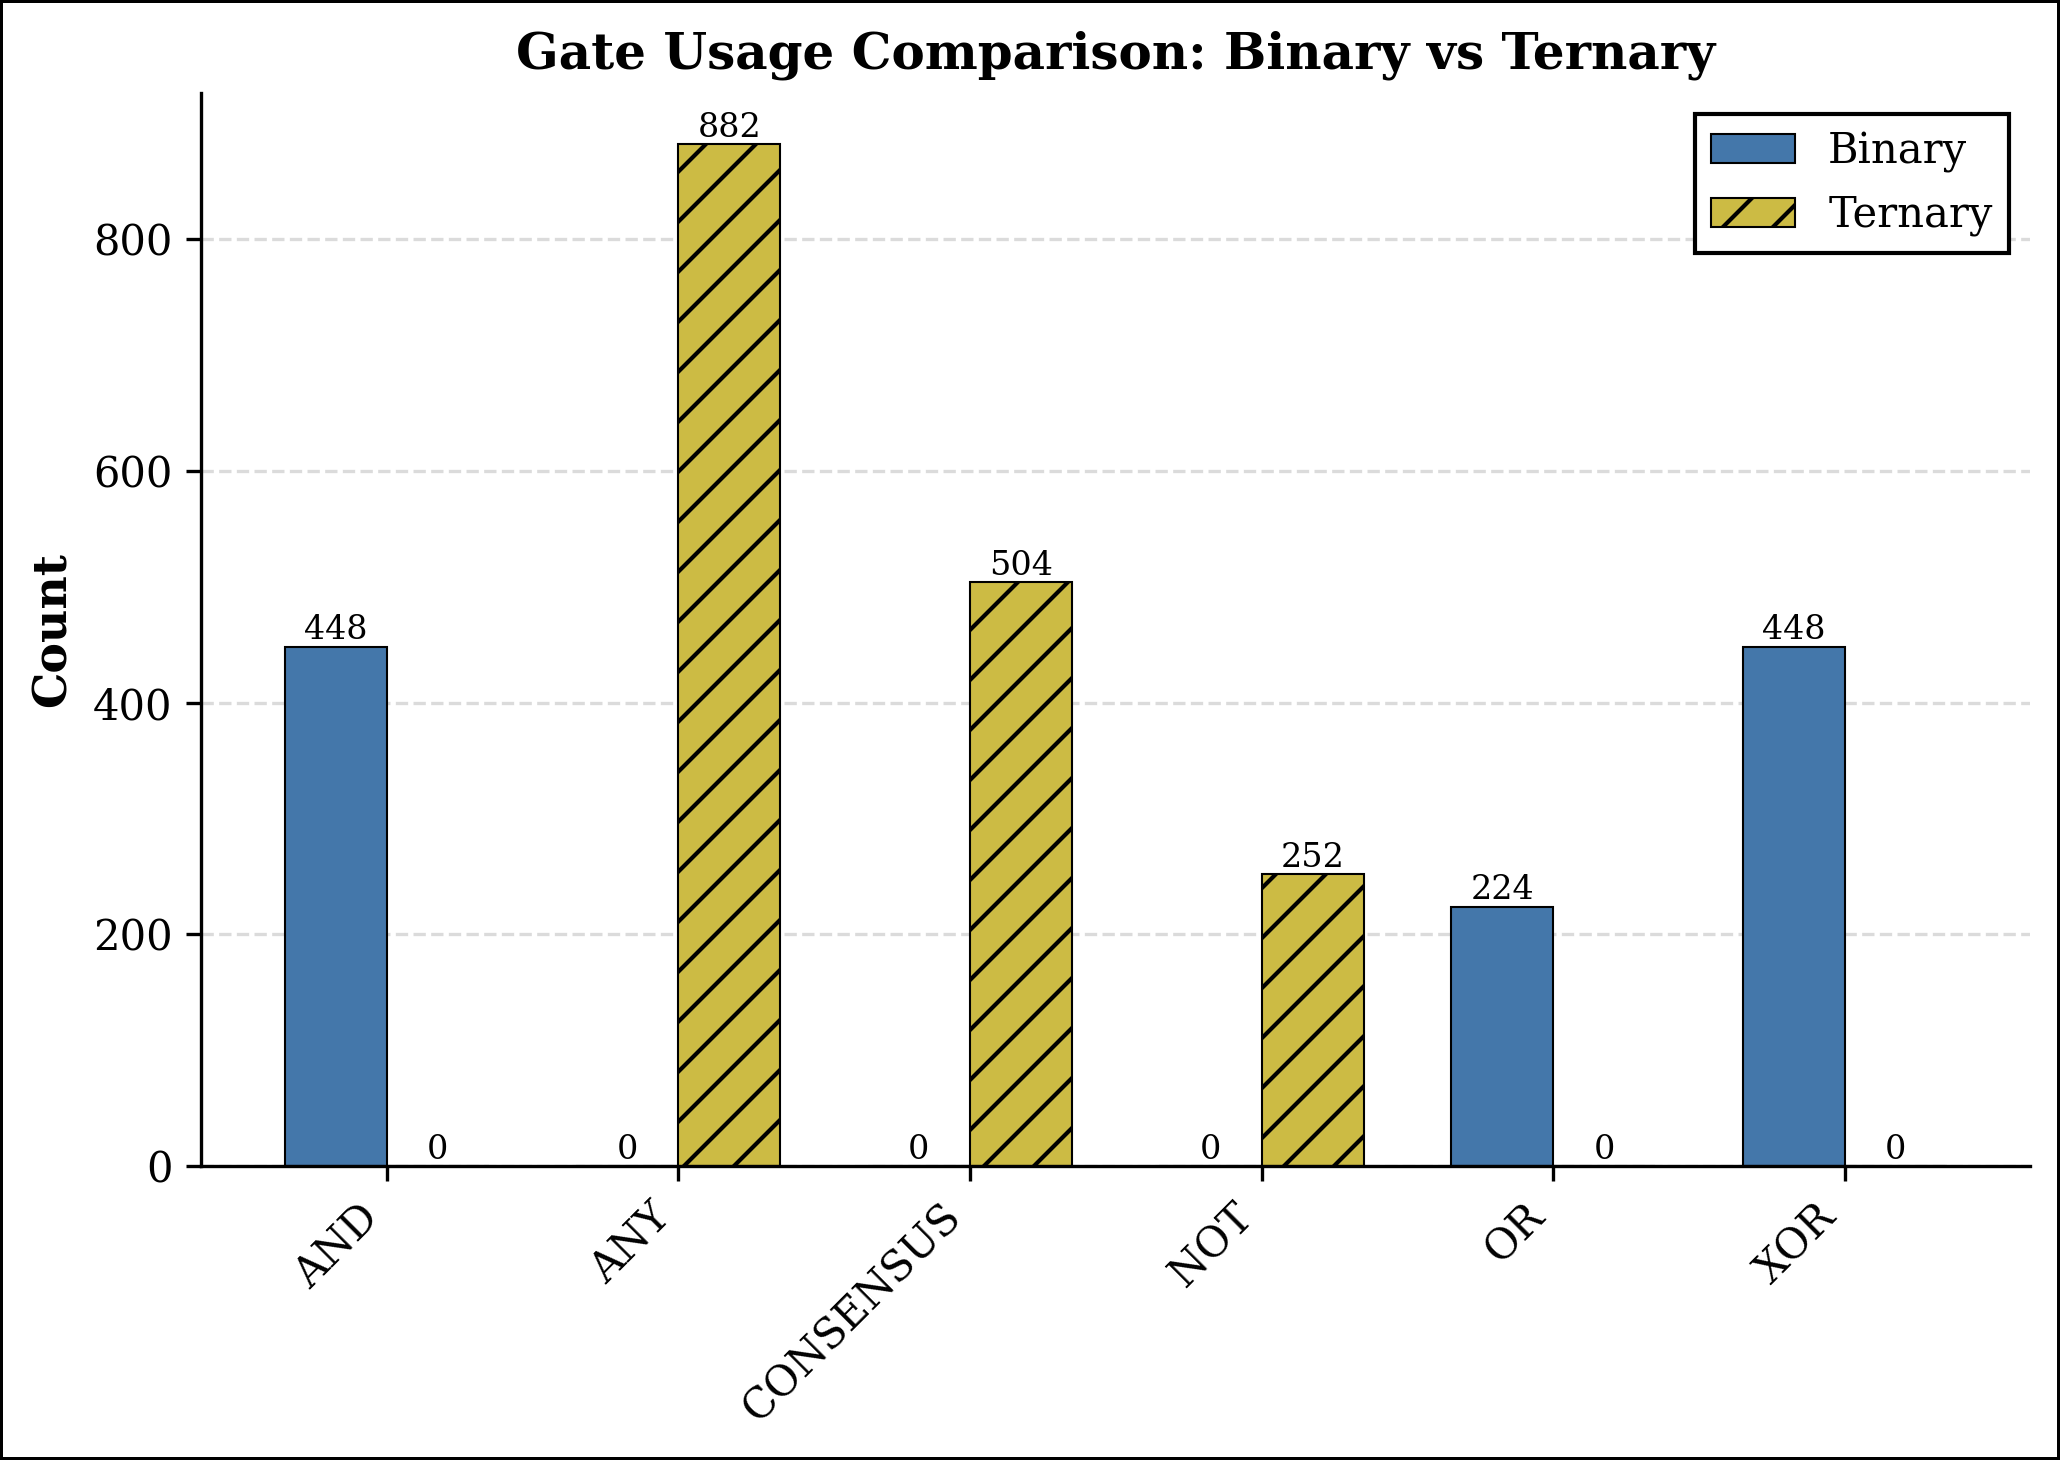

In [5]:
# Set up the figure and axes with a clean, academic style
plt.rcParams.update({
    'font.family': 'serif',  # Serif fonts are standard in academic papers
    'font.size': 10,         # Base font size
    'axes.labelsize': 11,    # Slightly larger axis labels
    'axes.titlesize': 12,    # Slightly larger title
    'xtick.labelsize': 10,   # Tick label size
    'ytick.labelsize': 10,   # Tick label size
    'legend.fontsize': 10,   # Legend font size
    'figure.dpi': 300        # High resolution for print
})

# Create figure with appropriate size for a single-column academic paper
# Standard single column width is often around 3.5 inches (8.9 cm)
fig, ax = plt.subplots(figsize=(7, 5))  # Width in inches, height adjusted for aspect ratio

# Use a color scheme that works well in both color and grayscale
# Using hatching patterns to differentiate bars even in grayscale
x = np.arange(len(all_gates))
width = 0.35

# Create bars with distinct patterns and colors
binary_bars = ax.bar(x - width/2, df['Binary'], width, label='Binary', 
                     color='#4477AA', edgecolor='black', linewidth=0.5, hatch='')
ternary_bars = ax.bar(x + width/2, df['Ternary'], width, label='Ternary', 
                      color='#CCBB44', edgecolor='black', linewidth=0.5, hatch='//')

# Configure axes
ax.set_xticks(x)
ax.set_xticklabels(all_gates, rotation=45, ha='right')  # Rotated labels to avoid overlap
ax.set_ylabel('Count', fontweight='bold')
ax.set_title('Gate Usage Comparison: Binary vs Ternary', fontweight='bold')

# Add gridlines for easier reading of values (light gray, dashed)
ax.yaxis.grid(True, linestyle='--', alpha=0.7, color='#cccccc')
ax.set_axisbelow(True)  # Place gridlines behind data

# Customize spines for cleaner look
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Add a subtle box around the legend and place it in an optimal position
ax.legend(frameon=True, framealpha=1, edgecolor='black', fancybox=False)

# Add count labels on top of each bar - smaller and more subtle
for i, v in enumerate(df['Binary']):
    ax.text(i - width/2, v + 0.5, str(v), ha='center', va='bottom', fontsize=8)

for i, v in enumerate(df['Ternary']):
    ax.text(i + width/2, v + 0.5, str(v), ha='center', va='bottom', fontsize=8)

# Add tight layout with specific padding for academic standards
plt.tight_layout(pad=1.2)

# Add a subtle border around the figure
fig.patch.set_linewidth(1)
fig.patch.set_edgecolor('black')

# Save the figure in publication-ready formats
# plt.savefig('gate_comparison.pdf', bbox_inches='tight')  # PDF for submission
# plt.savefig('gate_comparison.tiff', dpi=300, bbox_inches='tight')  # TIFF for publication
# plt.savefig('gate_comparison.eps', format='eps', bbox_inches='tight')  # EPS for certain journals

plt.show()

In [6]:
# 2. Pie charts
binary_total = sum(binary_counts.values())
ternary_total = sum(ternary_counts.values())

binary_labels = [f"{gate}\n({count}, {count/binary_total:.1%})" for gate, count in binary_counts.items()]
ternary_labels = [f"{gate}\n({count}, {count/ternary_total:.1%})" for gate, count in ternary_counts.items()]

ax2.pie(binary_counts.values(), labels=binary_labels, autopct='', startangle=90, 
        wedgeprops={'alpha': 0.6}, radius=1)
ax2.pie(ternary_counts.values(), labels=ternary_labels, autopct='', startangle=90, 
        wedgeprops={'alpha': 0.6}, radius=0.7)

centre_circle = plt.Circle((0, 0), 0.4, fc='white')
ax2.add_patch(centre_circle)

ax2.set_title('Gate Distribution (Outer: Binary, Inner: Ternary)')

# Add a title for the whole figure
plt.suptitle('Binary vs Ternary Logic: Gate Usage Analysis', fontsize=16)

plt.tight_layout()
plt.show()

NameError: name 'ax2' is not defined

In [7]:
# 3. Ratio comparison (separate visualization)
plt.figure(figsize=(10, 6))

ratios = []
for gate in all_gates:
    binary_val = binary_counts.get(gate, 0)
    ternary_val = ternary_counts.get(gate, 0)
    
    # Avoid division by zero
    if binary_val > 0 and ternary_val > 0:
        ratio = ternary_val / binary_val
        ratios.append((gate, ratio))

if ratios:
    ratios.sort(key=lambda x: x[1], reverse=True)
    gates_with_ratios, ratio_values = zip(*ratios)
    
    plt.bar(gates_with_ratios, ratio_values, color='purple')
    plt.axhline(y=1, color='r', linestyle='-', alpha=0.3)
    
    plt.title('Ternary/Binary Gate Usage Ratio')
    plt.ylabel('Ratio (Ternary ÷ Binary)')
    plt.xticks(rotation=45)
    
    # Add ratio values on top of each bar
    for i, v in enumerate(ratio_values):
        plt.text(i, v + 0.05, f"{v:.2f}x", ha='center')
    
    plt.tight_layout()
    plt.show()

<Figure size 3000x1800 with 0 Axes>

## CNFET vs. CMOS Propagation Delay

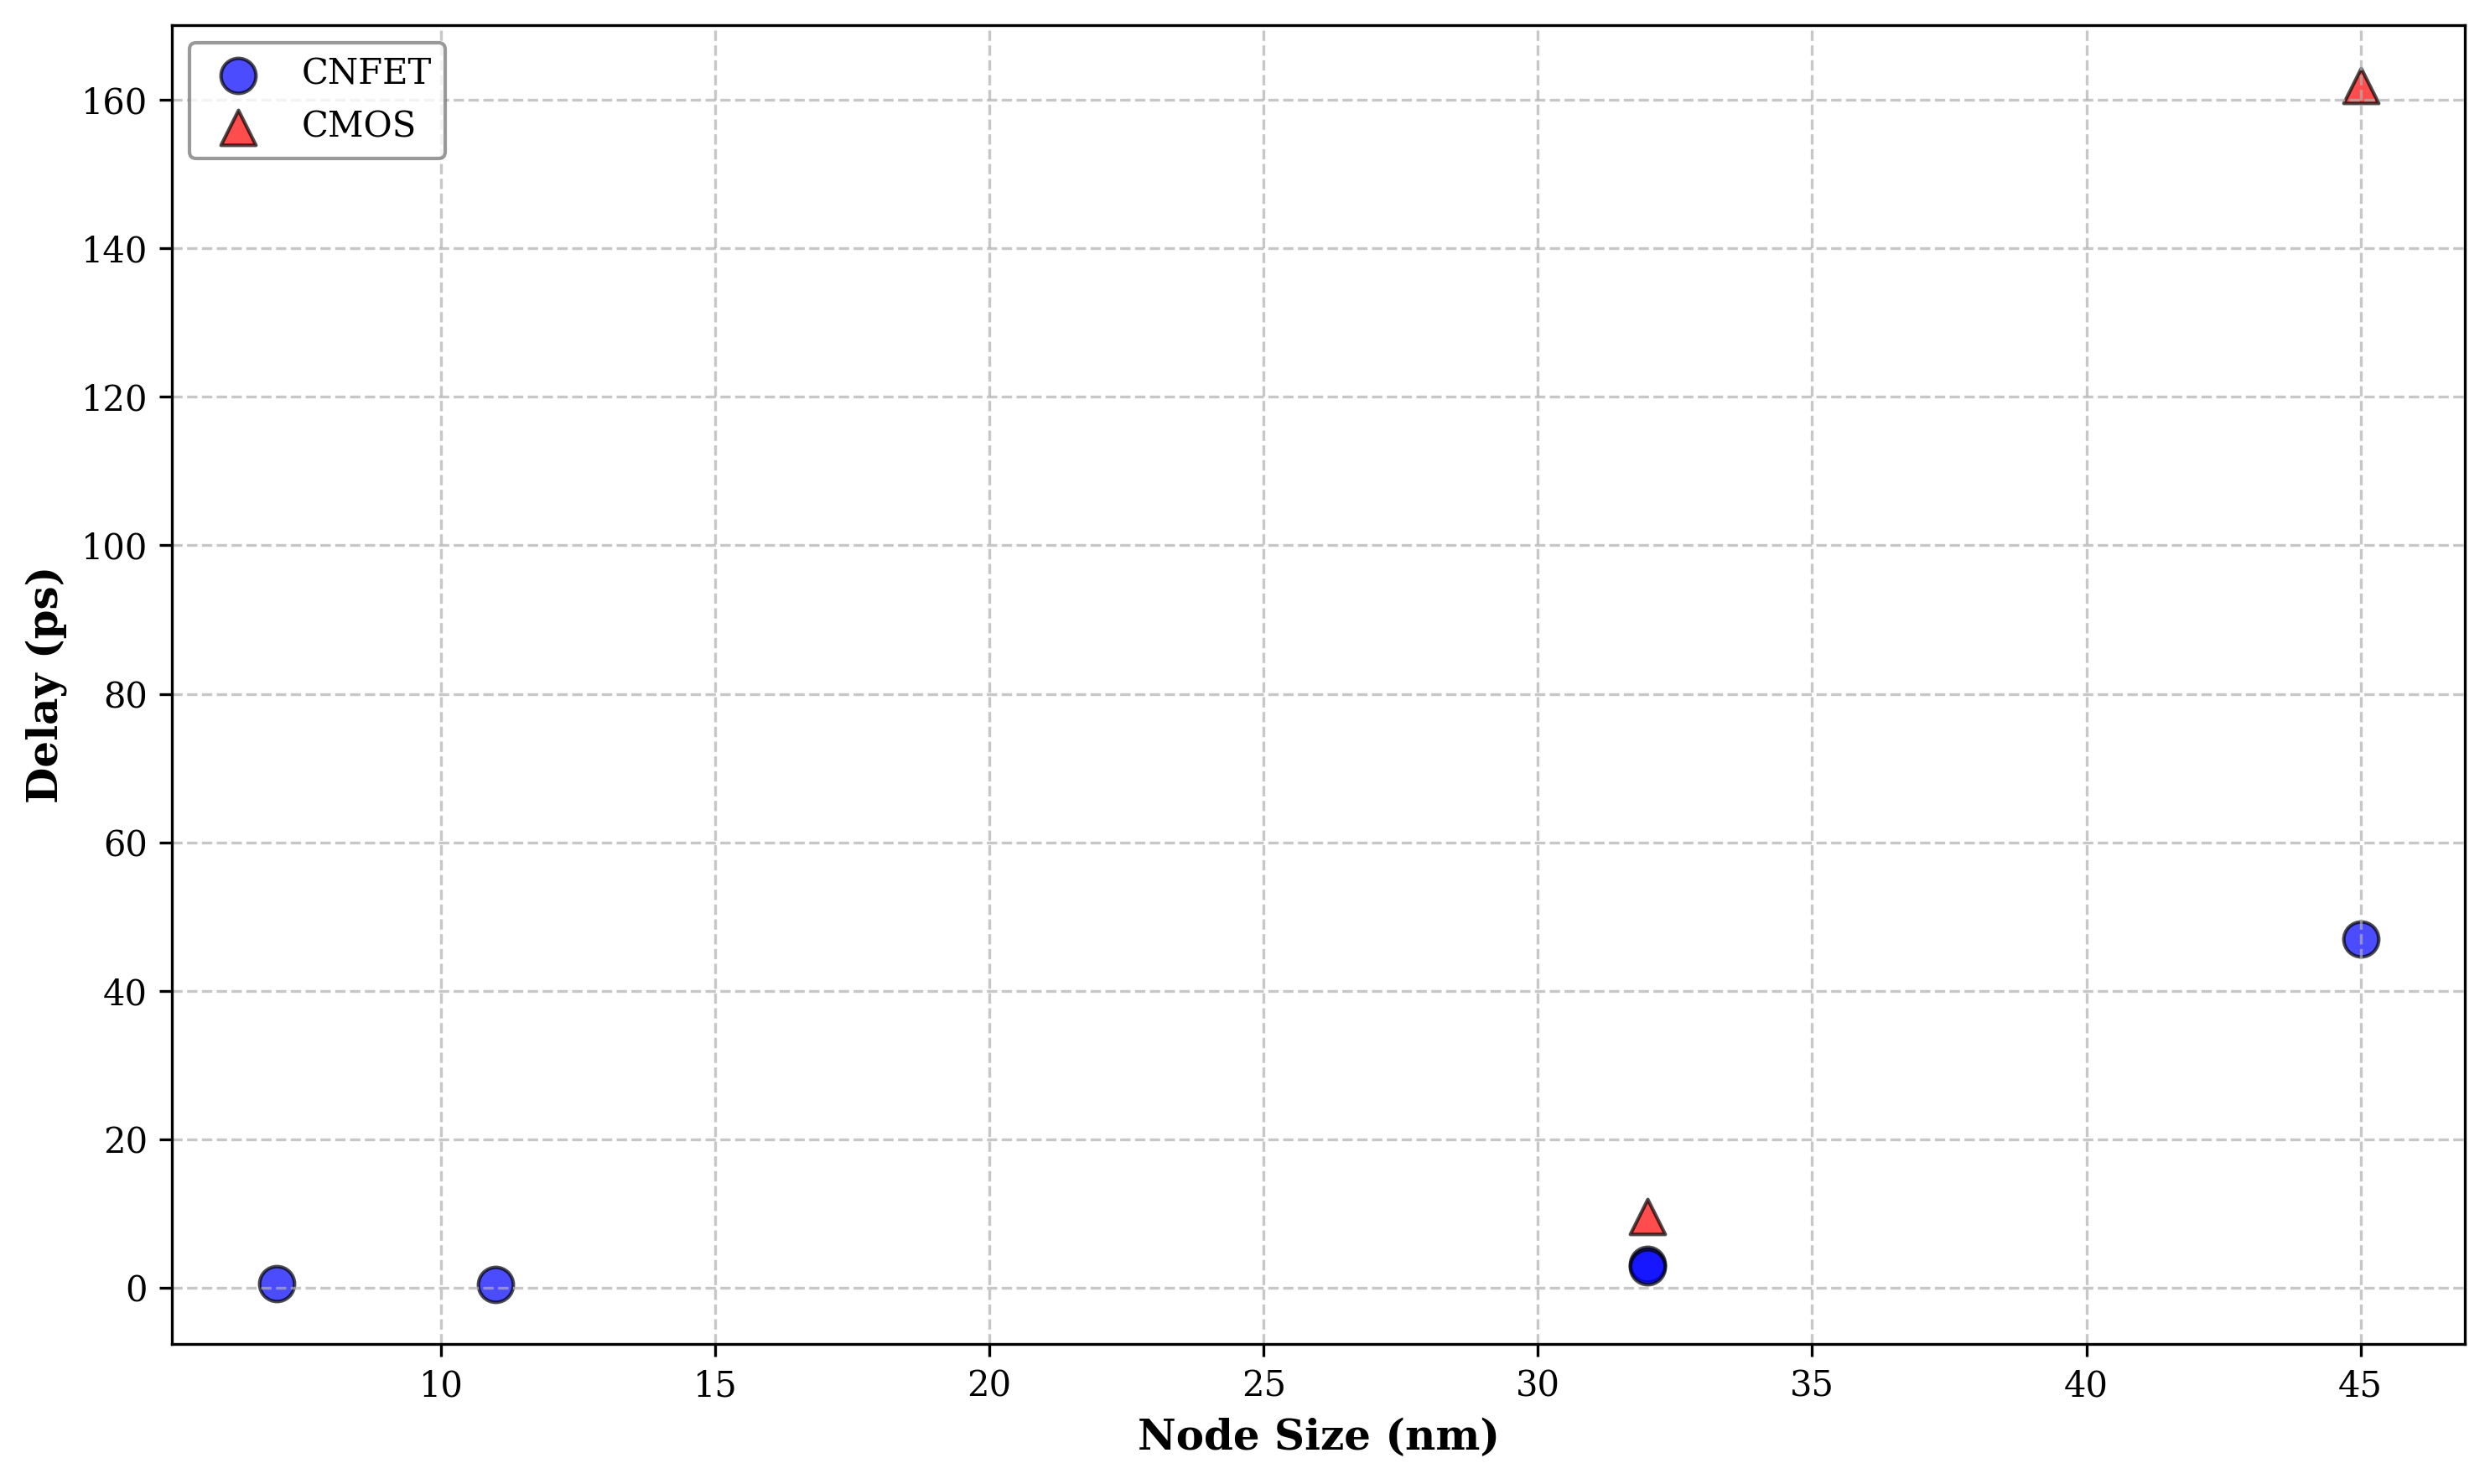

In [8]:
# Data from the table
gates = ['CNFET', 'CNFET', 'CNFET', 'CMOS', 'CNFET', 'CNFET', 'CMOS']
node_sizes = [11, 7, 45, 45, 32, 32, 32]
delays = [0.48, 0.55, 47, 162, 3.11, 2.79, 9.55]

# gates = ['CNFET', 'CNFET', 'CNFET', 'CNFET', 'CMOS']
# node_sizes = [11, 7, 32, 32, 32]
# delays = [0.48, 0.55, 3.11, 2.79, 9.55]

# Create the scatter plot
plt.figure(figsize=(10, 6))

# Separate CNFET and CMOS data
cnfet_sizes = [size for size, gate in zip(node_sizes, gates) if gate == 'CNFET']
cnfet_delays = [delay for delay, gate in zip(delays, gates) if gate == 'CNFET']
cmos_sizes = [size for size, gate in zip(node_sizes, gates) if gate == 'CMOS']
cmos_delays = [delay for delay, gate in zip(delays, gates) if gate == 'CMOS']

# Plot CNFET data
plt.scatter(cnfet_sizes, cnfet_delays, color='blue', marker='o', label='CNFET', 
            edgecolors='black', linewidth=1, alpha=0.7, s=100)

# Plot CMOS data
plt.scatter(cmos_sizes, cmos_delays, color='red', marker='^', label='CMOS', 
            edgecolors='black', linewidth=1, alpha=0.7, s=100)

# Customize the plot
plt.xlabel('Node Size (nm)', fontsize=12, fontweight='bold')
plt.ylabel('Delay (ps)', fontsize=12, fontweight='bold')
# plt.title('Comparison of CNFET and CMOS - Node Size vs Delay', 
        #   fontsize=14, fontweight='bold')
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(frameon=True, framealpha=0.8, edgecolor='gray')

# Add a tight layout and show the plot
plt.tight_layout()
plt.savefig('Diss/figures/cnfet_cmos_scatter.png', dpi=300, bbox_inches='tight')
plt.show()

## LUI Instruction Visualisation

findfont: Generic family 'serif' not found because none of the following families were found: Computer Modern Roman
findfont: Generic family 'serif' not found because none of the following families were found: Computer Modern Roman
findfont: Generic family 'serif' not found because none of the following families were found: Computer Modern Roman
findfont: Generic family 'serif' not found because none of the following families were found: Computer Modern Roman
findfont: Generic family 'serif' not found because none of the following families were found: Computer Modern Roman
findfont: Generic family 'serif' not found because none of the following families were found: Computer Modern Roman
findfont: Generic family 'serif' not found because none of the following families were found: Computer Modern Roman
findfont: Generic family 'serif' not found because none of the following families were found: Computer Modern Roman
findfont: Generic family 'serif' not found because none of the following

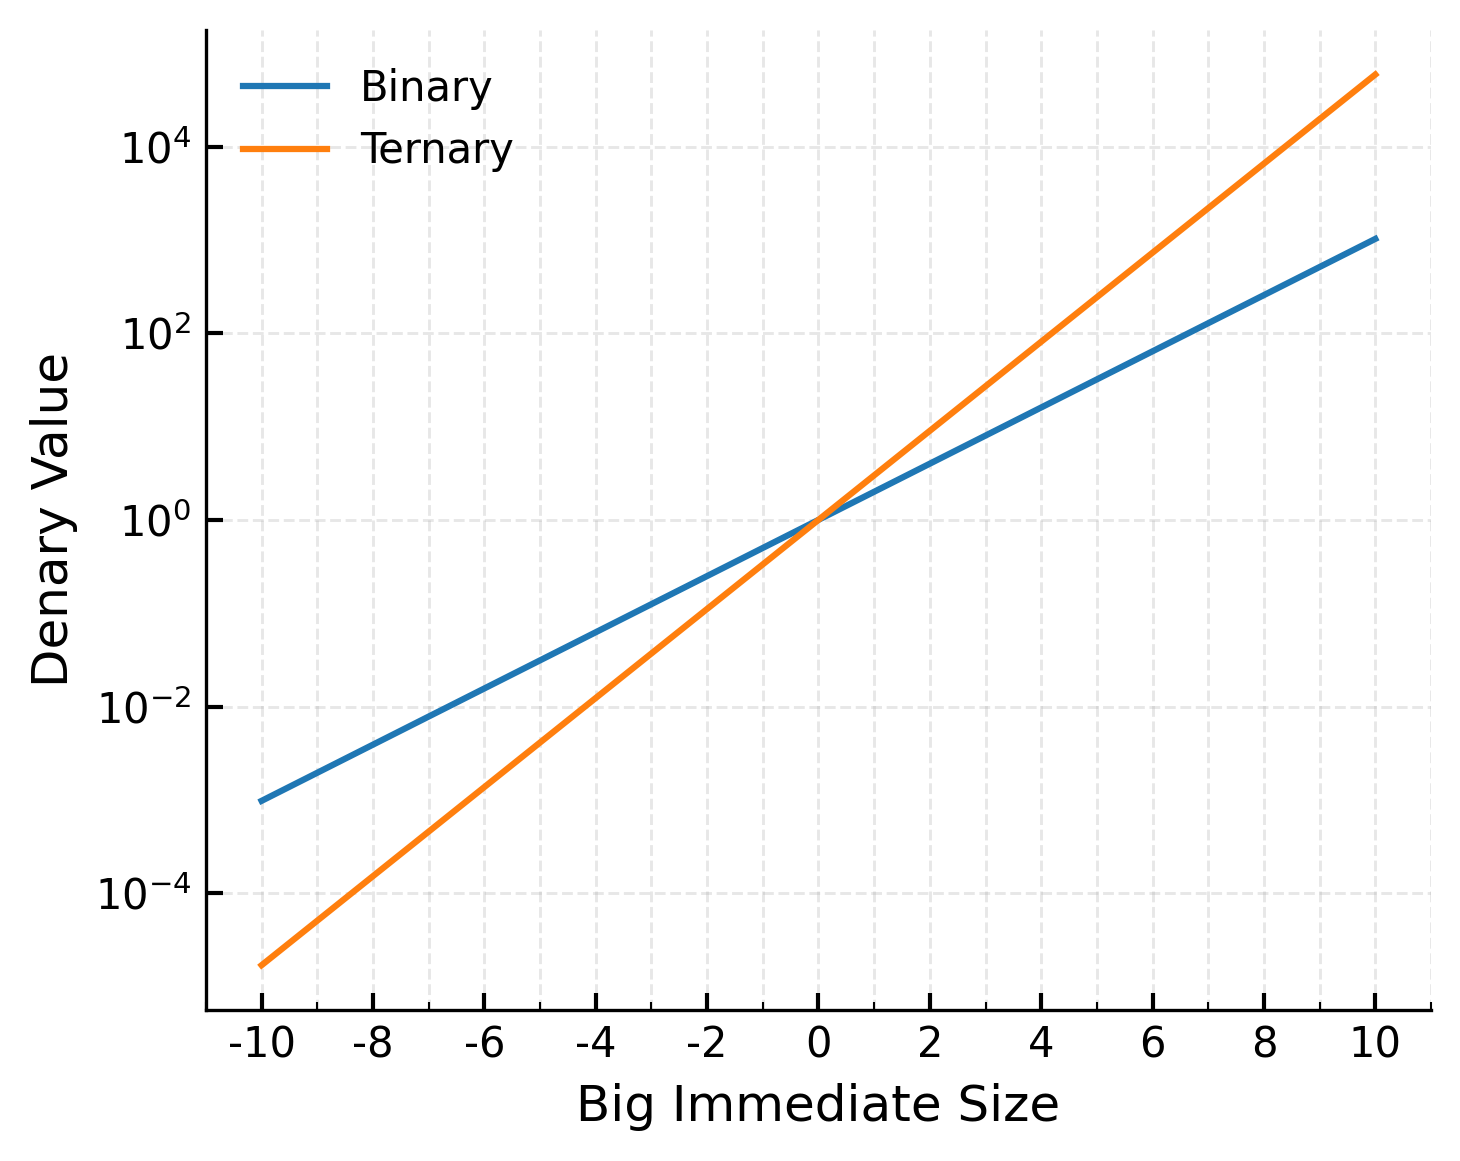

In [24]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams
import matplotlib as mpl
import matplotlib.ticker as ticker

# Set up the matplotlib parameters for academic style WITHOUT LaTeX
plt.rcParams.update({
    'font.size': 11,
    'text.usetex': False,  # Disable LaTeX rendering
    'mathtext.default': 'regular',  # Still use math formatting
    'axes.labelsize': 12,
    'axes.titlesize': 12,
    'xtick.labelsize': 10,
    'ytick.labelsize': 10,
    'legend.fontsize': 10,
    'figure.figsize': (5, 4),
    'figure.dpi': 300,
    'axes.grid': True,
    'grid.alpha': 0.3,
    'lines.linewidth': 1.5,
    'axes.axisbelow': True,
    'axes.spines.top': False,
    'axes.spines.right': False,
})

# Create x values
x = np.linspace(-10, 10, 1000)

# Calculate y values
y1 = 2**x
y2 = 3**x

# Create the figure and axis
fig, ax = plt.subplots()

# Plot the functions
ax.semilogy(x, y1, label='Binary', color='#1f77b4')
ax.semilogy(x, y2, label='Ternary', color='#ff7f0e')

# Adjust grid
ax.grid(True, which="both", linestyle='--', linewidth=0.7)

# Set integer ticks on x-axis
ax.xaxis.set_major_locator(ticker.MultipleLocator(2))  # Major ticks every 2 units
ax.xaxis.set_minor_locator(ticker.MultipleLocator(1))  # Minor ticks every 1 unit
ax.xaxis.set_major_formatter(ticker.FormatStrFormatter('%d'))  # Format as integers

# Add labels and title
ax.set_xlabel('Big Immediate Size')
ax.set_ylabel('Denary Value')

# Adjust tick marks
ax.tick_params(direction='in', length=4, width=1)
ax.tick_params(which='minor', direction='in', length=2, width=0.5)

# Add legend
ax.legend(frameon=False)

# Adjust layout
plt.tight_layout()

plt.savefig('Diss/figures/exponential_functions.png', bbox_inches='tight', dpi=300)
plt.show()